In [1]:
import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import matplotlib.pyplot as plt
import xesmf

### Import data
load the daily NOAA OISST v2.1 avhrr-only dataset 

In [2]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True, decode_timedelta =True)

# Take the first zlevel only and resample to monthly means
ds = ds.sel(zlev = ds.zlev[0]).resample(time='MS').mean()

print(ds)

<xarray.Dataset>
Dimensions:  (time: 478, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    zlev     float32 0.0
Data variables:
    anom     (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err      (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ice      (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>


### Resample data to 1º grid using xESMF

In [4]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90.5, 1)),
                     'lon': (['lon'], np.arange(0.5, 360.5, 1)),
                    }
                   )

regridder = xesmf.Regridder(ds, ds_out, 'bilinear')
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_720x1440_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (720, 1440) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

In [5]:
ds_out = regridder(ds)
ds_out

/srv/conda/envs/mhw-hackathon/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


<xarray.Dataset>
Dimensions:  (time: 478, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
    zlev     float32 0.0
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    anom     (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    err      (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ice      (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    sst      (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

/srv/conda/envs/mhw-hackathon/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


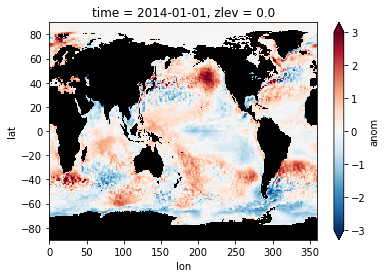

In [6]:
ds_out.anom.sel(time=('2014-01-01')).plot(vmin=-3, vmax=3, cmap='RdBu_r')
plt.gca().patch.set_color('black')

### Transform time into decimal year and add it as a new coordinate --> `da.dyr`

In [8]:
years = pd.DatetimeIndex(ds_out.time.values).year
months = pd.DatetimeIndex(ds_out.time.values).month
dyr = []
for i in enumerate(years):
    I = i[1] + ((months[i[0]]-0.5)/12)
    dyr.append(I)
dyr = np.array(dyr)

### Decompose SST fields into mean, trend, annual, and semi-annual harmonics


In [ ]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':ds_out.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':ds_out.time.values})  

# resulting coefficients of the model
sst_mod = pmodel_da.dot(ds_out.sst) 


In [15]:
# Construct mean, trend, and seasonal cycle
mean = model_da[:,0].dot(sst_mod[0,:,:])
trend = model_da[:,1].dot(sst_mod[1,:,:])
seas = model_da[:,2:].dot(sst_mod[2:,:,:])

### Get the SST anomalies 

In [17]:
# compute anomalies (SSTa) by removing model coefficients
ssta = ds_out.sst-model_da.dot(sst_mod[[0,2,3,4,5],:,:])

In [18]:
# Plot weighted global mean timeseries of SSTA with and without trend
dlon = np.cos(ds_out.lat * np.pi/180) *111e3
dlat = 111e3 * xr.ones_like(ds_out.lon)
cell_area = dlon * dlat

ssta.weighted(cell_area).mean(('lat','lon')).plot(label='no trend')
plt.legend(frameon=False); plt.ylabel('SSTA');

/srv/conda/envs/mhw-hackathon/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

### Add a landmask

In [21]:
path = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/lsmask.oisst.nc'
ds_mask = xr.open_dataset(path, use_cftime=True) 
lsmask = ds_mask.lsmask.isel(time=0)

# regrid landmask
lsmask_out = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90.5, 1)),
                         'lon': (['lon'], np.arange(0.5, 360.5, 1)),
                        }
                       )

regridder = xesmf.Regridder(lsmask, lsmask_out, 'bilinear')
lsmask_out = regridder(lsmask)


/srv/conda/envs/mhw-hackathon/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/srv/conda/envs/mhw-hackathon/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### Save SSTA to netCDF

In [22]:
# Specify path to save output 
path = '/home/jovyan/marineHeatwave-image-classification/data/'

ds_new = xr.Dataset(
    data_vars=dict(
        lsmask = (['lat', 'lon'], lsmask_out.data),
        ssta = (['time', 'lat', 'lon'], ssta.data),
        mean = (['time', 'lat', 'lon'], mean.data),
        trend = (['time', 'lat', 'lon'], trend.data),
        seas = (['time', 'lat', 'lon'], seas.data),
             
    ),
    coords=dict(
        time=(['time'], ds_out.time.data),
        lat=(['lat'], ds_out.lat.data),
        lon=(['lon'], ds_out.lon.data),
    ),
    attrs=dict(description="preprocessed monthly averaged OISST v2.1 anomalies"),
)


ds_new.to_netcdf(path+'preprocessed_OISSTv21.nc', mode='w')


In [23]:
ds_new.nbytes / 1e9 # MB

0.991707344